<a href="https://colab.research.google.com/github/ufangYang/computational-neuroscience/blob/main/Results_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

includes some visualizations

In [ ]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [ ]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
#@title Data loading
import numpy as np
import sklearn as sk
from sklearn.manifold import TSNE

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [ ]:
# PLEASE RUN ME :)
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
zc = np.array([])
for mouseind in range(0,len(alldat)):
  wheelvel_m1 = np.squeeze(alldat[mouseind]['wheel'])
  cnt = []
  for trial in range(0,wheelvel_m1.shape[0]):
    currtrial = wheelvel_m1[trial,:]
    indices_one = np.abs(currtrial) <= 2
    currtrial[indices_one] = 0
    smoothedtrial = smooth(currtrial,10)
    #if trial == 0:
     # plt.plot(smoothedtrial)
      #plt.show()
    zero_crossings = np.where(np.diff(np.sign(smoothedtrial)))[0]
    #if trial == 0:
    #  print(zero_crossings)
    cnt.append(len(zero_crossings))
  zc=np.hstack((zc,cnt))





`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

In [ ]:
#PLEASE RUN ME
## put data in right format
# for all markers: wheel velocity, licking, reaction time, feedback, pupil size, changes of mind

leftcontrast = np.unique(alldat[0]['contrast_left'])
rightcontrast = np.unique(alldat[0]['contrast_right'])


all_wheel = alldat[0]['wheel']
all_leftcont = alldat[0]['contrast_left']
all_rightcont = alldat[0]['contrast_right']
all_feedback = alldat[0]['feedback_type']
all_response = alldat[0]['response']
all_licking = alldat[0]['licks']
all_pupilsize = alldat[0]['pupil']
all_reaction = alldat[0]['reaction_time'][:,0]
#added
all_feedbacktime = np.squeeze(alldat[0]['feedback_time'])


for mouseind in range(1,len(alldat)):
  all_wheel = np.hstack((all_wheel,alldat[mouseind]['wheel']))
  all_leftcont = np.hstack((all_leftcont,alldat[mouseind]['contrast_left']))
  all_rightcont = np.hstack((all_rightcont,alldat[mouseind]['contrast_right']))
  all_feedback = np.hstack((all_feedback,alldat[mouseind]['feedback_type']))
  all_response = np.hstack((all_response,alldat[mouseind]['response']))
  all_licking = np.hstack((all_licking,alldat[mouseind]['licks']))
  all_pupilsize = np.hstack((all_pupilsize,alldat[mouseind]['pupil']))
  all_reaction = np.hstack((all_reaction,alldat[mouseind]['reaction_time'][:,0]))
  # added
  all_feedbacktime = np.hstack((all_feedbacktime,np.squeeze(alldat[mouseind]['feedback_time'][:,0])))



## function for contrast differences and number of unique contrasts
def cdiff(left,right):
  all_contrdiff = np.abs(left - right)
  unique = np.unique(all_contrdiff)
  return all_contrdiff, unique

#[all_contrdiff,all_contrunique] = cdiff(all_leftcont,all_rightcont)

#prepare all arrays

#velocity: take average over time samples 60 to 80
vel_finished = np.mean(all_wheel[0,:,60:80],axis=1) # old version
#added: 
# vel_finished = np.mean(all_wheel[0,:,60:90],axis=1)

#licking: take average of licking over certain timepoints
# lick_finished = np.mean(all_licking[0,:,0:51], axis = 1) # old version
# added
lick_finished = np.zeros((all_licking.shape[1],))
for trials in range (0,all_licking.shape[1]):
  endbin = all_feedbacktime[trials]*100
  endbin = round(np.ceil(endbin))
  if endbin > 250:
    endbin = 250
  lick_finished[trials] = np.mean(all_licking[0,trials,0:endbin], axis = 0)


#pupil: take average
pupil_finished = np.mean(all_pupilsize[0,:,100:150],axis=1)


leftcont_finished = all_leftcont
rightcont_finished = all_rightcont
feedback_finished = all_feedback
reaction_finished = all_reaction
zerocount_finished = zc
##changes of mind
#combine all variables into one array (columns: variable, rows: timepoints)
combined_input = np.array([zerocount_finished, vel_finished, lick_finished, pupil_finished,feedback_finished, reaction_finished,leftcont_finished,rightcont_finished]).T

# process combined_input: take out all trials where rt = inf & where contright=contleft=0
#take out No Go trials
nogotrials = (combined_input[:,6] == 0) & (combined_input[:,7] == 0)
withoutNoGo = combined_input[~nogotrials,:]

#find and take out inf trials
InfTr = np.isinf(withoutNoGo[:,5])
withoutInf = withoutNoGo[~InfTr,:]

# take only variables of interest and cut out stimulus difference on the right and left
Klaus = withoutInf[:, 0:6]

X = Klaus
y = np.abs(withoutInf[:,6]-withoutInf[:,7])
print(y.shape)
print(X.shape)

(6034,)
(6034, 6)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


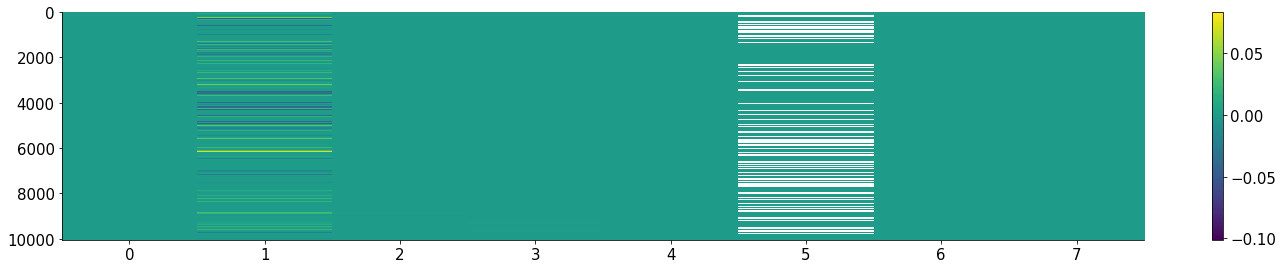

In [ ]:
plt.imshow(combined_input / np.sum(combined_input,0), aspect='auto', interpolation='none')
plt.colorbar()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

(-7.5, 7.5)

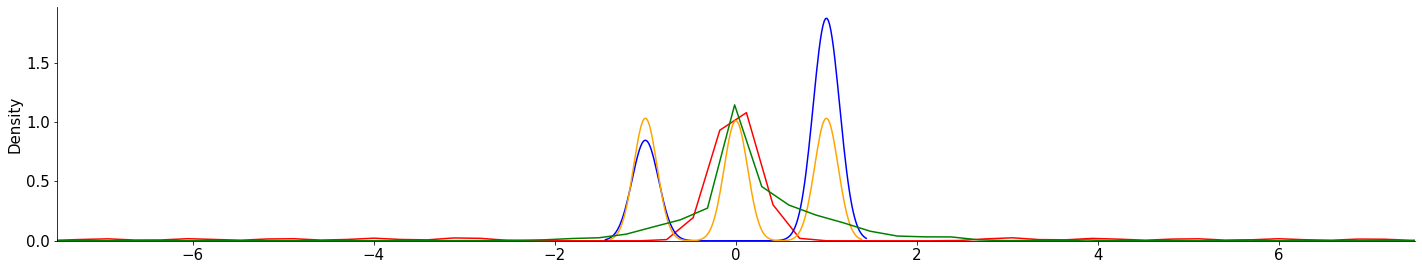

In [ ]:
import seaborn as sns
# plot
#fig, axes = plt.subplots(1, 5, figsize=(10, 3), sharey=True, dpi=100)
sns.distplot(all_wheel,hist=False,color='r')
sns.distplot(all_feedback,hist=False,color='blue')
sns.distplot(all_response,hist=False,color='orange')
sns.distplot(all_pupilsize,hist=False,color='green')
#sns.distplot(all_reaction, axlabel='RT')
plt.xlim(-7.5, 7.5)




# New section

In [ ]:
#PLEASE RUN ME
#normalize

for column in range(0,6):
  calc_mean = np.mean(X[:,column], axis=0)
  calc_std = np.std(X[:,column],axis=0)
  norm_column = (X[:,column]-calc_mean)/ calc_std
  Klaus[:,column]=norm_column

X = Klaus # X is now normalized!!! 

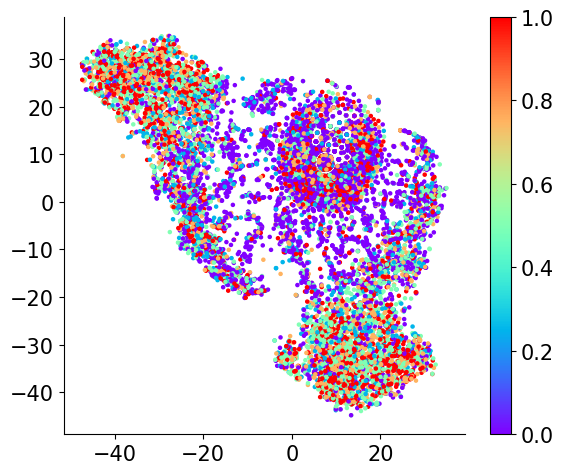

In [ ]:
# velocity and perplexity = 100


# zerocount_finished, vel_finished, lick_finished, pupil_finished, feedback_finished, reaction_finished, leftcont_finished, rightcont_finished

from sklearn.manifold import TSNE
#X_embedded = TSNE(n_components=2, random_state=19, n_iter=1000, perplexity=100).fit_transform(X[:,np.array([1])])
X_embedded = TSNE(n_components=2, random_state=19, n_iter=1000, perplexity=100).fit_transform(np.squeeze(all_wheel))


#colors = (y, X[:,4])[0]
label = np.abs(all_leftcont-all_rightcont)
colors = label
f, ax = plt.subplots(1,1, figsize=(6,5), dpi=100)
im = ax.scatter(X_embedded[:,0], X_embedded[:,1], cmap='rainbow', c=colors, s=5)
plt.colorbar(im)



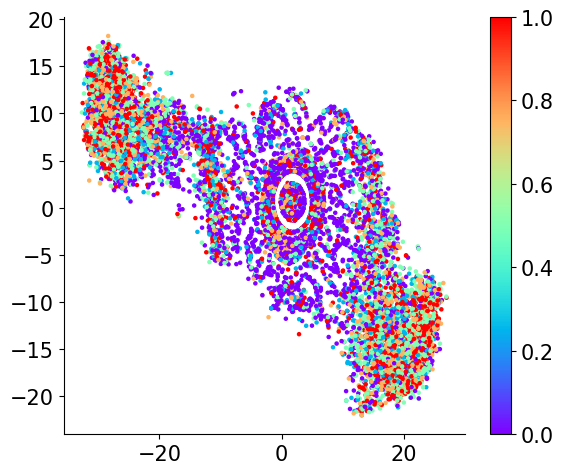

In [ ]:
#velocity and perplexity = 300


#X_embedded = TSNE(n_components=2, random_state=19, n_iter=1000, perplexity=100).fit_transform(X[:,np.array([1])])
X_embedded = TSNE(n_components=2, random_state=19, n_iter=1000, perplexity=300).fit_transform(np.squeeze(all_wheel))


#colors = (y, X[:,4])[0]
label = np.abs(all_leftcont-all_rightcont)
colors = label
f, ax = plt.subplots(1,1, figsize=(6,5), dpi=100)
im = ax.scatter(X_embedded[:,0], X_embedded[:,1], cmap='rainbow', c=colors, s=5)
plt.colorbar(im)

(10050, 750)


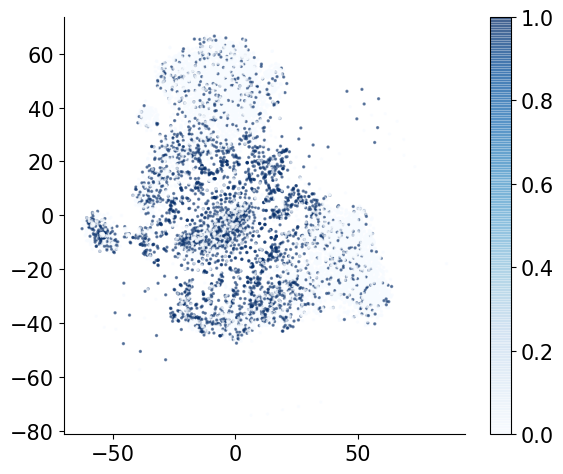

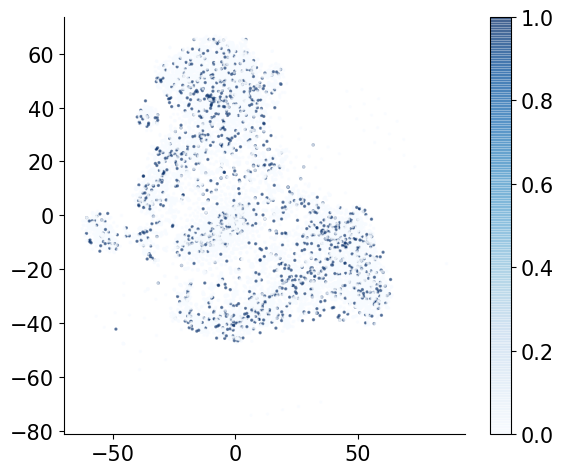

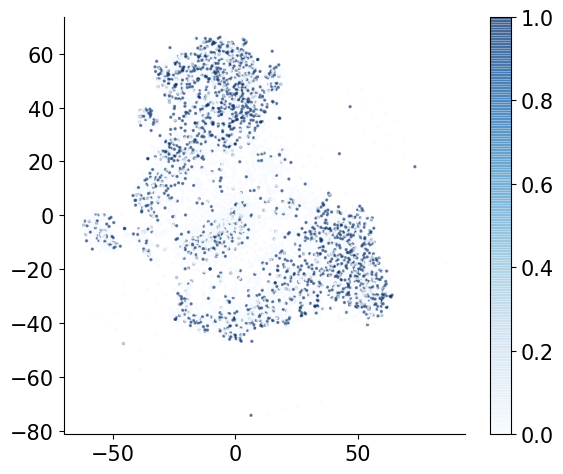

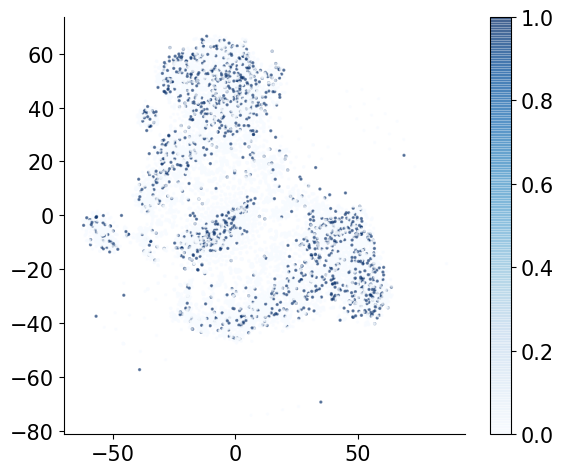

In [ ]:
#wl = np.vstack((all_wheel, all_licking))
wh = np.squeeze(all_wheel)
ll = np.squeeze(all_licking)
zz = np.hstack((wh,ll))
pp = all_pupilsize[0,:,:]
multiplevar = np.hstack((zz,pp))
print(multiplevar.shape)

#X_embedded = TSNE(n_components=2, random_state=19, n_iter=1000, perplexity=100).fit_transform(multiplevar)

#colors = (np.array([0, 0.25,0.5,0.75])==0)
#colors = (y, X[:,4])[0]
label = np.abs(all_leftcont-all_rightcont)
for p in [0, 0.25,0.5,0.75]:
  colors = (label == p)*1
  f, ax = plt.subplots(1,1, figsize=(6,5), dpi=100)
  im = ax.scatter(X_embedded[:,0], X_embedded[:,1], cmap='Blues', c=colors, s=2, alpha=.5)
  plt.colorbar(im)

In [ ]:
np.digitize(0.05, bins = np.array([0,0.25, 0.5]))

In [ ]:
# Normalization (Min-Max) YF 

for column in range(0,6):
  calc_min = np.min(X[:,column], axis=0)
  calc_max = np.max(X[:,column],axis=0)
  norm_column = (X[:,column]-calc_min)/ (calc_max-calc_min)
  Klaus[:,column]=norm_column

X = Klaus # Lee # :D :D LOVE IT! :D --> from Judith


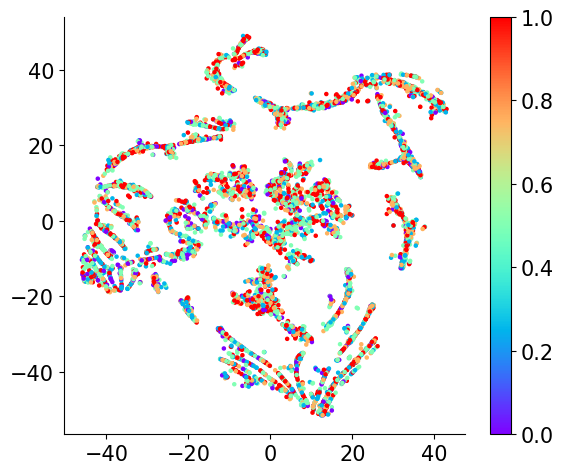

In [ ]:
# zerocount_finished, vel_finished, lick_finished, pupil_finished, feedback_finished, reaction_finished, leftcont_finished, rightcont_finished

from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, random_state=49, n_iter=1000, perplexity=100).fit_transform(X[:,np.array([0,1,2,3,5])])


colors = (y, X[:,4])[0]
f, ax = plt.subplots(1,1, figsize=(6,5), dpi=100)
im = ax.scatter(X_embedded[:,0], X_embedded[:,1], cmap='rainbow', c=colors, s=5)
plt.colorbar(im)

In [ ]:
#split into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Text(0, 0.5, 'number of trials')

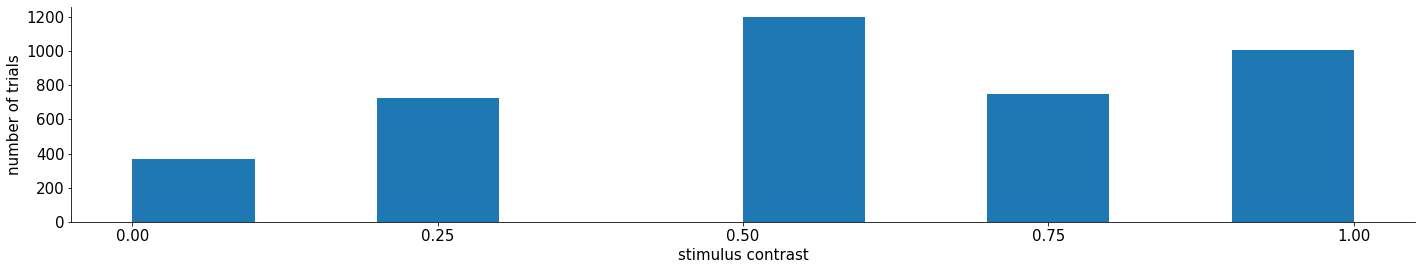

In [ ]:
# plot how many trials for each stimulus difference

plt.hist(y_train)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0]) 
plt.xlabel('stimulus contrast')
plt.ylabel('number of trials')

For n_clusters = 2 The average silhouette_score is : 0.6342866034734863


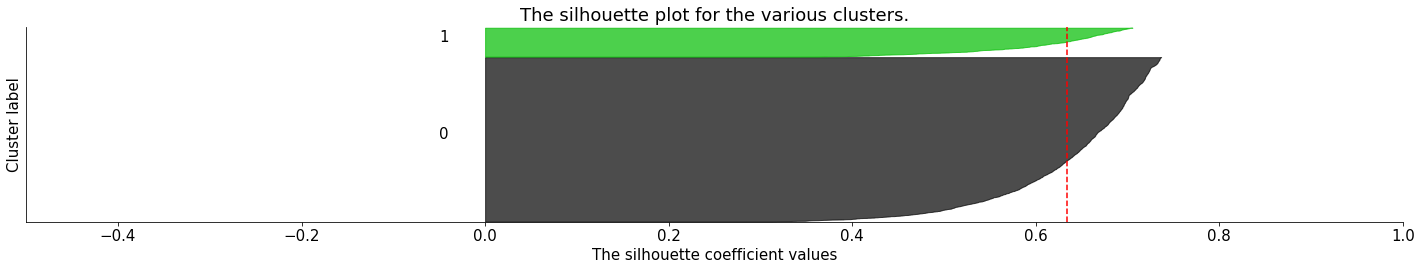

For n_clusters = 3 The average silhouette_score is : 0.40365918605084566


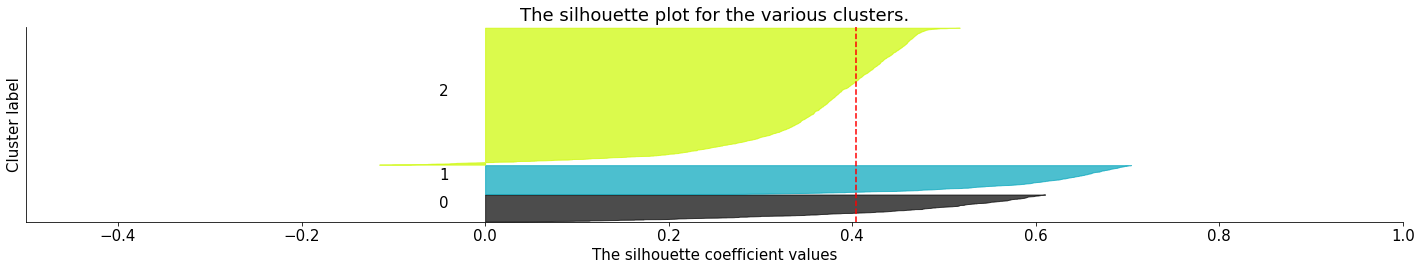

For n_clusters = 4 The average silhouette_score is : 0.3261951441690811


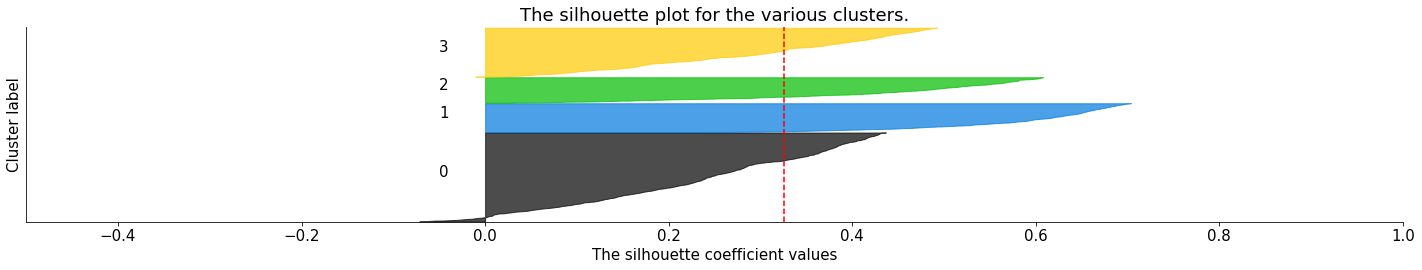

For n_clusters = 5 The average silhouette_score is : 0.3574665057564683


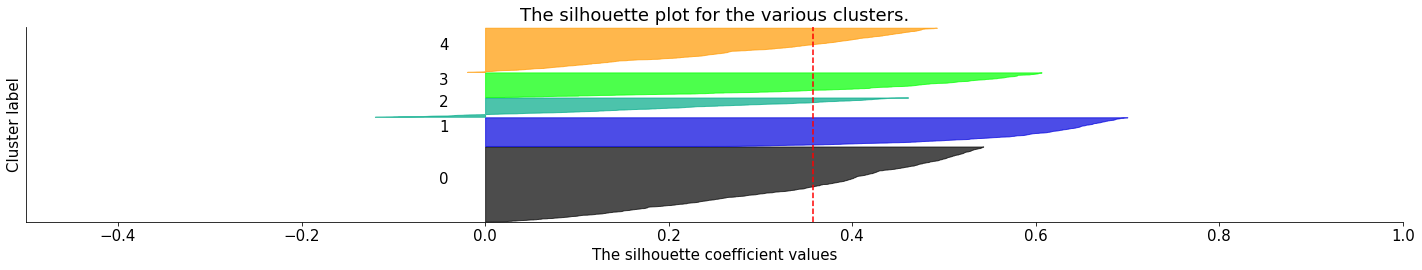

For n_clusters = 6 The average silhouette_score is : 0.3374070608150738


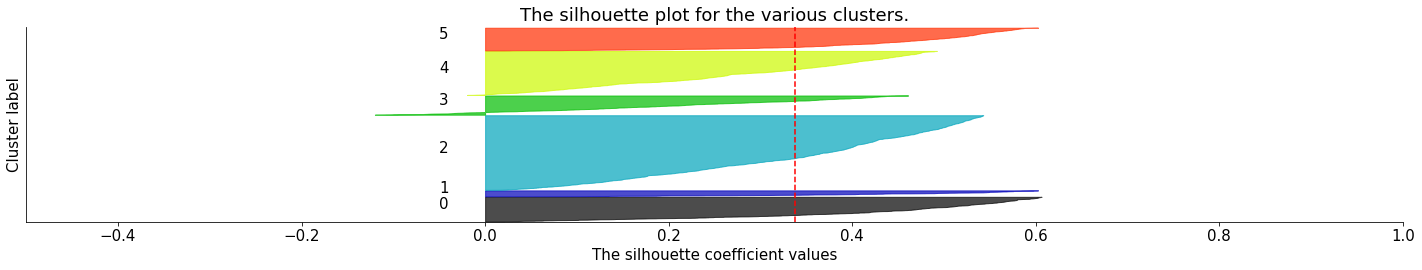

For n_clusters = 7 The average silhouette_score is : 0.31629004613284234


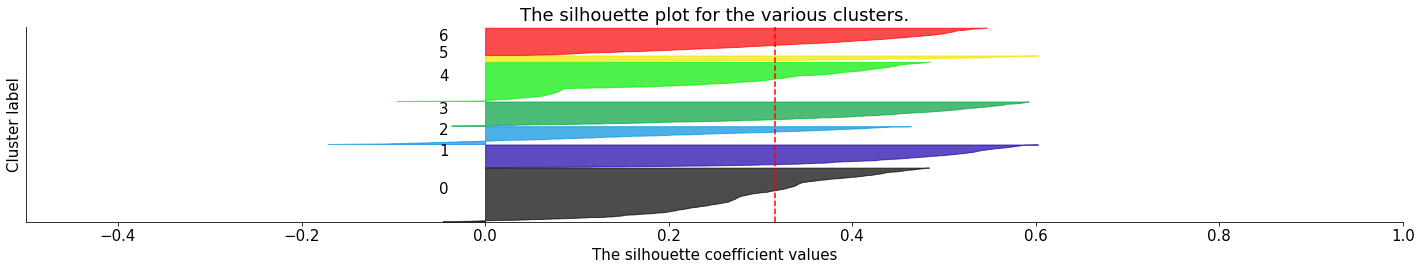

For n_clusters = 8 The average silhouette_score is : 0.3064941552845911


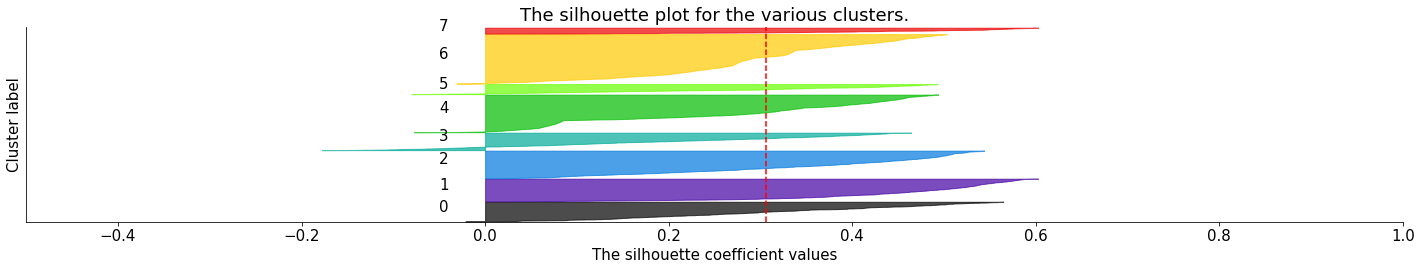

For n_clusters = 9 The average silhouette_score is : 0.2905371772855808


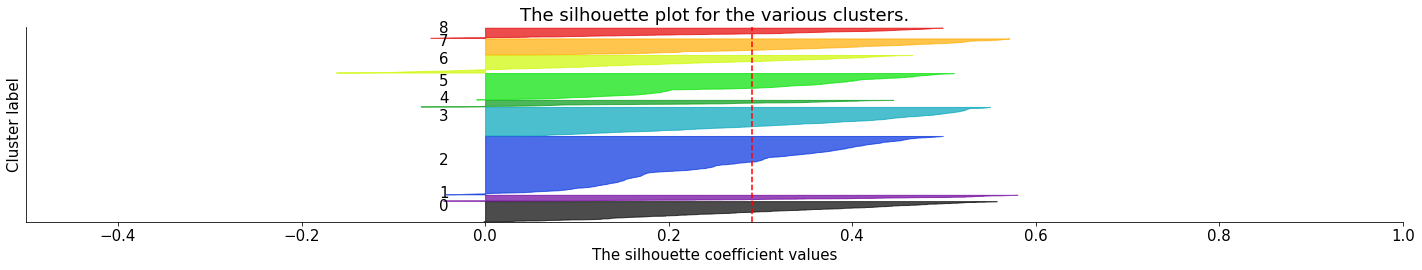

For n_clusters = 10 The average silhouette_score is : 0.2757484309274052


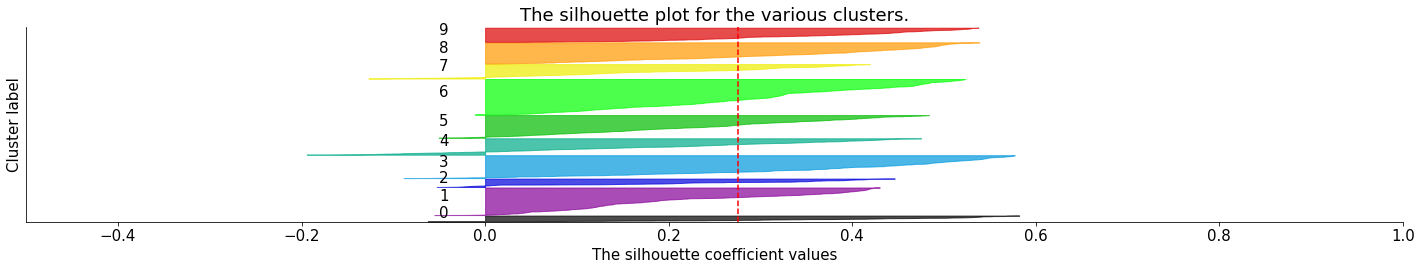

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:

    # The silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.5, 1]
    plt.xlim([-0.5, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(X_train) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init = 'k-means++', random_state=10)
    cluster_labels = clusterer.fit_predict(X_train)
    if n_clusters==5:
      setclusterlabel = cluster_labels
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
#part 2, still in the loop 

# Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

In [ ]:
#divide labels into easy (-1) and hard (1)
import copy

easy_versus_hard_trials = copy.deepcopy(y_train) # need deepcopy to not overwrite y_train
easytrials = [0.5, 0.75, 1.0]
for et in easytrials:
  easyind = (y_train==et)
  easy_versus_hard_trials[easyind]= -1 # easy

hardtrials = [0, 0.25]
for ht in hardtrials:
  hardind = (y_train==ht)
  easy_versus_hard_trials[hardind]= 1 # hard

<BarContainer object of 5 artists>

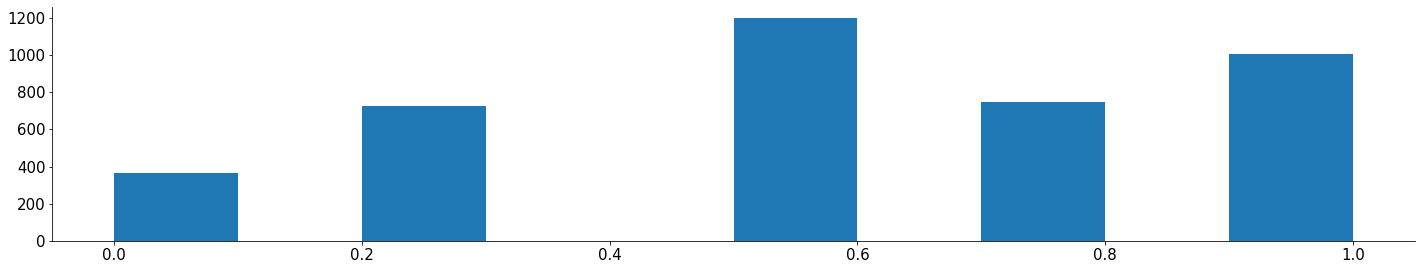

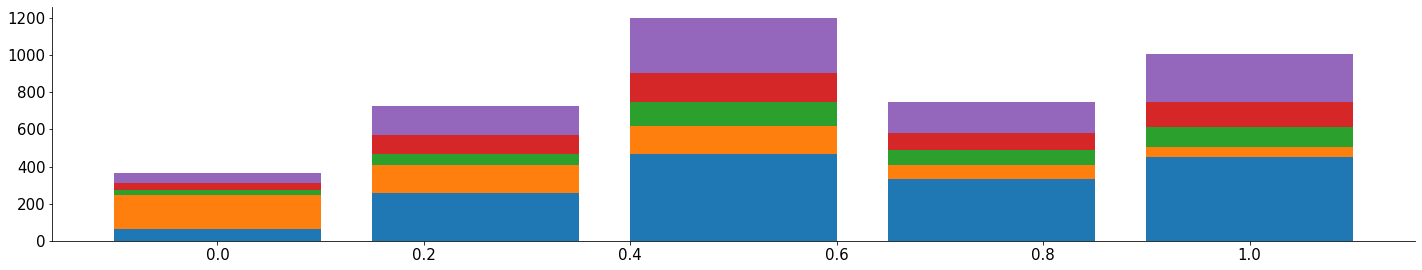

In [ ]:
plt.hist(y_train)
differences = np.unique(y_train)
coltrials = np.zeros((5,5))
for cluster in range(0,5):
  clusterind = (setclusterlabel == cluster)
  for i, difference in enumerate(differences):
    diffind = (y_train[clusterind]==difference)
    count = np.sum(diffind)
    coltrials[cluster, i] = count

cluster1 = coltrials[0,:]
cluster2 = coltrials[1,:]
cluster3 = coltrials[2,:]
cluster4 = coltrials[3,:]
cluster5 = coltrials[4,:]
labels = [0, 0.25, 0.5, 0.75, 1.0]


fig, ax = plt.subplots()
width = 0.2

ax.bar(labels, cluster1, width, label='cluster 1')
ax.bar(labels, cluster2, width, bottom= cluster1, label='Cluster2')
ax.bar(labels, cluster3, width, bottom = cluster1+cluster2, label='Cluster3')
ax.bar(labels, cluster4, width, bottom = cluster1+cluster2+cluster3, label='Cluster4')
ax.bar(labels, cluster5, width, bottom=cluster1+cluster2+cluster3+cluster4,label='cluster5')


In [ ]:


# evaluate multinomial logistic regression model
from numpy import mean
from numpy import std
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

y=pd.Categorical(y)
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

ValueError: ignored